# Project

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import statistics
import random
#from geneticalgorithm import geneticalgorithm as ga

In [ ]:
from google.colab import files

uploaded = files.upload()  # Opens file selection window

Saving sample_grid.csv to sample_grid.csv


## Loading Map and Temperature

In [ ]:
# ===============================================================
# 1. Caricamento e preparazione della mappa
# ===============================================================
def load_map(filename='sample_grid.csv'):
    """
    Carica la mappa da un file CSV, crea le pivot table per il tipo e la temperatura,
    e restituisce le matrici, la pivot e i mapping per i tipi.
    """
    df = pd.read_csv(filename)

    # Mappatura dei tipi a valori numerici
    type_to_num = {'building': 0, 'road': 1, 'green_space': 2, 'water': 3}
    num_to_type = {v: k for k, v in type_to_num.items()}
    df['type_num'] = df['type'].map(type_to_num)

    # Creazione delle pivot table per i tipi e le temperature
    type_pivot = df.pivot(index='y', columns='x', values='type_num')
    temp_pivot = df.pivot(index='y', columns='x', values='temp_fac')

    # Ordina righe e colonne per allineamento
    type_pivot = type_pivot.sort_index(ascending=True).sort_index(axis=1, ascending=True)
    temp_pivot = temp_pivot.sort_index(ascending=True).sort_index(axis=1, ascending=True)

    # Conversione in array NumPy per accesso rapido
    type_matrix = type_pivot.values
    temp_matrix = temp_pivot.values

    return type_matrix, temp_matrix, type_pivot, type_to_num, num_to_type

# Caricamento della mappa
type_matrix, temp_matrix, type_pivot, type_to_num, num_to_type = load_map('sample_grid.csv')
H, W = type_matrix.shape

## Initial data description

### Data Visualisation

=== Statistiche iniziali ===
Media: 29.85
Massimo: 35.00
Minimo: 22.50
Varianza: 5.60
Mediana: 30.00


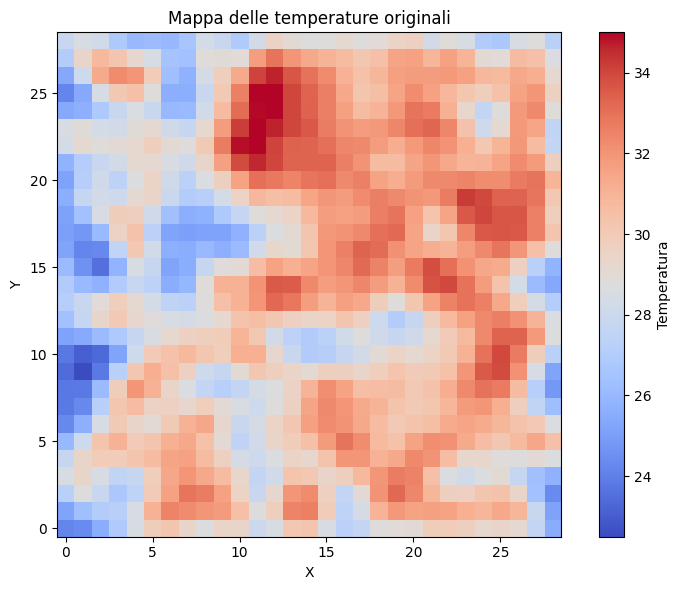

In [ ]:
# Statistiche iniziali
original_mean = np.mean(temp_matrix)
original_max = np.max(temp_matrix)
original_min = np.min(temp_matrix)
original_var = np.var(temp_matrix)
original_median = np.median(temp_matrix)

print("=== Statistiche iniziali ===")
print("Media: {:.2f}".format(original_mean))
print("Massimo: {:.2f}".format(original_max))
print("Minimo: {:.2f}".format(original_min))
print("Varianza: {:.2f}".format(original_var))
print("Mediana: {:.2f}".format(original_median))

# Definizione dei limiti per la scala delle temperature (per visualizzazione)
vmin = original_min
vmax = original_max

# Visualizzazione della mappa delle temperature originali
plt.figure(figsize=(8, 6))
plt.imshow(temp_matrix, origin='lower', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.title("Mappa delle temperature originali")
plt.xlabel("X")
plt.ylabel("Y")
cbar = plt.colorbar()
cbar.set_label("Temperature")
plt.tight_layout()
plt.show()


## Heat Island Visualization

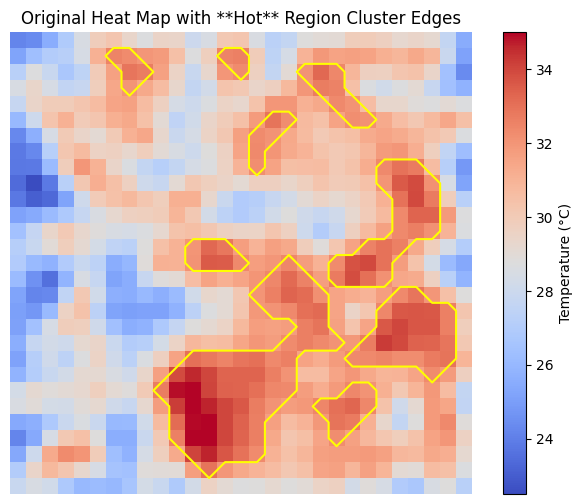

In [ ]:

from scipy.ndimage import binary_dilation

def get_heat_islands(temp_matrix,threshold=32):
  from sklearn.cluster import DBSCAN

  # Get grid dimensions
  H, W = temp_matrix.shape

  # Get all coordinates (y, x)
  y_coords, x_coords = np.indices((H, W))
  coords = np.column_stack((y_coords.ravel(), x_coords.ravel()))

  # Flatten temperature matrix
  temps = temp_matrix.ravel()

  # Select hot regions
  hot_mask = temps >= threshold
  hot_coords = coords[hot_mask]

  # Apply DBSCAN clustering to detect hot areas
  dbscan = DBSCAN(eps=1.5, min_samples=3)
  hot_clusters = dbscan.fit_predict(hot_coords)

  # Create cluster grid (initialize with -1)
  cluster_grid = np.full((H, W), fill_value=-1)
  for (y, x), cluster_label in zip(hot_coords, hot_clusters):
      cluster_grid[y, x] = cluster_label

  return cluster_grid,hot_clusters

def get_heat_island_edges(temp_matrix):
  from scipy.ndimage import binary_dilation

  cluster_grid,hot_clusters = get_heat_islands(temp_matrix)

  # Identify cluster edges
  edges = np.zeros_like(cluster_grid, dtype=bool)
  for cluster_label in np.unique(hot_clusters[hot_clusters >= 0]):
      cluster_mask = cluster_grid == cluster_label
      dilated_mask = binary_dilation(cluster_mask, structure=np.ones((3, 3)))  # Use a 3x3 structuring element
      edge = dilated_mask & cluster_mask  # Edges are within the hot regions
      edges |= edge

  return edges

# Visualization: Heatmap with cluster edges
plt.figure(figsize=(8, 6))
plt.imshow(temp_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Temperature (°C)")
plt.contour(get_heat_island_edges(temp_matrix), colors='yellow', linewidths=1.5)
plt.title("Original Heat Map with **Hot** Region Cluster Edges")
plt.axis('off')
plt.show()

## Problem parameter description

In [ ]:
# ===============================================================
# 2. Parametri del problema e proprietà degli elementi raffreddanti
# ===============================================================
num_candidates = 20   # Numero massimo di candidati (elementi potenzialmente piazzati)
budget_max = 6000    # Budget massimo in CHF

# Proprietà degli alberi:
# Tipo 0: Albero "potente" – costo elevato, raffreddamento maggiore
# Tipo 1: Albero "economico" – costo inferiore, raffreddamento minore
tree_properties = {
    0: {'cost': 300, 'cooling': 6, 'radius': 1},
    1: {'cost': 300, 'cooling': 1, 'radius': 8}
}

# Proprietà della Fontana
fountain_properties = {
    'cost': 3500,
    'cooling': 4.5,
    'radius': 4
}

# Parametri dei pesi per il multi-obiettivo
w_mean = 1.0   # Peso per la temperatura media
w_max  = 1.0   # Peso per la temperatura massima (hot spot)


## Objective Function definition

In [ ]:
# ===============================================================
# 3. Funzione obiettivo multi-obiettivo
# ===============================================================
def objective(solution):
    """
    Minimizza una funzione obiettivo multi-criterio che combina la temperatura media e
    la temperatura massima finale dopo aver applicato l'effetto raffreddante.

    Il vettore decisionale 'solution' ha dimensione 4 * num_candidates:
      [row1, col1, active1, type1, ..., rowN, colN, activeN, typeN]

    I possibili valori per 'type' sono:
      - 0: Albero "potente"
      - 1: Albero "economico"
      - 2: Fontana (posizionabile solo in zone 'green_space')

    Penalità:
      - Posizione fuori dalla griglia.
      - Albero su building.
      - Fontana in zona diversa da 'green_space'.
      - Costo totale oltre il budget.
      - Raggio d'azione che esce dalla mappa.
    """
    penalty = 0
    total_cost = 0
    active_elements = []  # Lista di tuple (row, col, candidate_type)

    # Decodifica del vettore decisionale
    for i in range(num_candidates):
        row = int(round(solution[4*i]))
        col = int(round(solution[4*i+1]))
        active = 1 if int(round(solution[4*i+2])) >= 1 else 0
        candidate_type = int(round(solution[4*i+3]))
        candidate_type = max(0, min(2, candidate_type))  # Forza candidate_type in [0,2]

        if active:
            # Controllo: posizione valida nella griglia
            if row < 0 or row >= H or col < 0 or col >= W:
                penalty += 1e6
                continue

            # Controlli specifici per il tipo di elemento
            if candidate_type == 2:
                # La fontana deve essere posizionata solo in aree green_space
                if type_matrix[row, col] != type_to_num['green_space']:
                    penalty += 1e6
                    continue
                else:
                    props = fountain_properties
            else:
                # Gli alberi non possono essere piazzati su building
                if type_matrix[row, col] == type_to_num['building']:
                    penalty += 1e6
                    continue
                else:
                    props = tree_properties[candidate_type]

            # Controllo che il raggio d'azione non esca dalla mappa
            r_effect = props['radius']
            if (row - r_effect < 0 or row + r_effect >= H or col - r_effect < 0 or col + r_effect >= W):
                penalty += 1e6

            total_cost += props['cost']
            active_elements.append((row, col, candidate_type))

    # Penalità se il costo totale supera il budget
    if total_cost > budget_max:
        penalty += 1e6 * (total_cost - budget_max)

    # Applicazione dell'effetto raffreddante con modello gaussiano
    final_temp = np.copy(temp_matrix)
    Y, X = np.indices((H, W))
    for (row_center, col_center, candidate_type) in active_elements:
        if candidate_type == 2:
            props = fountain_properties
        else:
            props = tree_properties[candidate_type]
        sigma = props['radius'] / 2.0
        dist2 = (Y - row_center)**2 + (X - col_center)**2
        effect = props['cooling'] * np.exp(-dist2 / (2 * sigma**2))
        final_temp -= effect

    # Calcolo dei due criteri: temperatura media e massima
    avg_temp = np.mean(final_temp)
    max_temp = np.max(final_temp)

    # Funzione obiettivo multi-criterio: combinazione pesata
    objective_value = w_mean * avg_temp + w_max * max_temp + penalty
    return objective_value


## GA definition

### decisional vectomr definition

In [ ]:
# ===============================================================
# 4. Definizione del vettore decisionale per il GA
# ===============================================================
# Ogni candidato ha 4 variabili: row, col, active, type
# Il bound per 'type' ora è [0, 2]: 0 e 1 per alberi, 2 per fontana
var_bound = []
for _ in range(num_candidates):
    var_bound.append([0, H-1])  # row
    var_bound.append([0, W-1])  # col
    var_bound.append([0, 1])    # active
    var_bound.append([0, 2])    # type
var_bound = np.array(var_bound)


### Algorhitm parameter

In [ ]:
# ===============================================================
# 5. Parametri dell'algoritmo genetico
# ===============================================================
params = {
    'max_num_iteration': 1000,
    'population_size': 100,
    'mutation_probability': 0.2,
    'elit_ratio': 0.05,
    'crossover_probability': 0.7,
    'parents_portion': 0.3,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': 500
}

# Single-Run

 The best solution found:                                                                           
 [21.  2.  0.  1. 20.  8.  1.  0.  7. 14.  0.  2. 21. 13.  0.  2. 16. 16.
  1.  0. 24.  9.  1.  2.  6. 24.  1.  0.  7. 12.  1.  0. 23. 24.  1.  0.
 20. 11.  0.  0. 17. 22.  1.  0. 25. 25.  0.  0.  4. 27.  0.  0. 12. 12.
  1.  0. 27.  0.  0.  0. 22. 15.  1.  0.  2. 17.  0.  2. 11. 15.  1.  2.
  5.  0.  0.  0. 23. 23.  1.  1.]

 Objective function:
 62.42843803107604


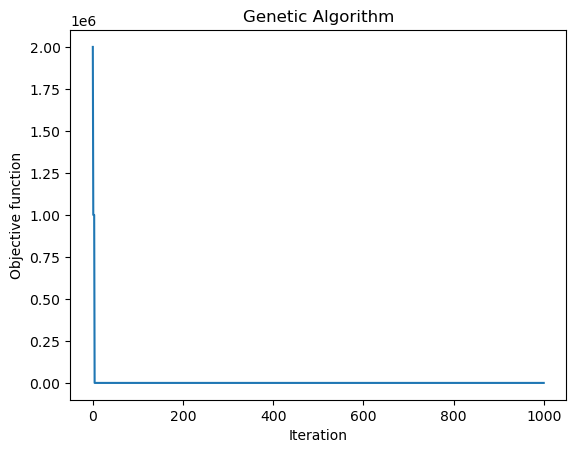


--- Risultato del singolo run ---
Migliore soluzione trovata: [21.  2.  0.  1. 20.  8.  1.  0.  7. 14.  0.  2. 21. 13.  0.  2. 16. 16.
  1.  0. 24.  9.  1.  2.  6. 24.  1.  0.  7. 12.  1.  0. 23. 24.  1.  0.
 20. 11.  0.  0. 17. 22.  1.  0. 25. 25.  0.  0.  4. 27.  0.  0. 12. 12.
  1.  0. 27.  0.  0.  0. 22. 15.  1.  0.  2. 17.  0.  2. 11. 15.  1.  2.
  5.  0.  0.  0. 23. 23.  1.  1.]
Elementi piazzati (alberi e fontane): 11
Posizione: (20, 8) - Tipo: Albero potente
Posizione: (16, 16) - Tipo: Albero potente
Posizione: (24, 9) - Tipo: Fontana
Posizione: (6, 24) - Tipo: Albero potente
Posizione: (7, 12) - Tipo: Albero potente
Posizione: (23, 24) - Tipo: Albero potente
Posizione: (17, 22) - Tipo: Albero potente
Posizione: (12, 12) - Tipo: Albero potente
Posizione: (22, 15) - Tipo: Albero potente
Posizione: (11, 15) - Tipo: Fontana
Posizione: (23, 23) - Tipo: Albero economico
Costo totale: 12580

=== Statistiche finali ottimizzate ===
Media: 27.87
Massimo: 33.93
Minimo: 16.48
Varianza: 8

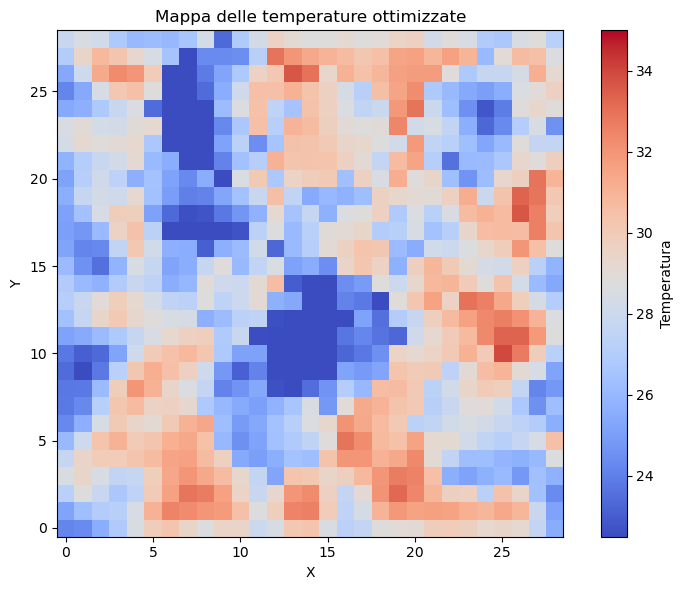

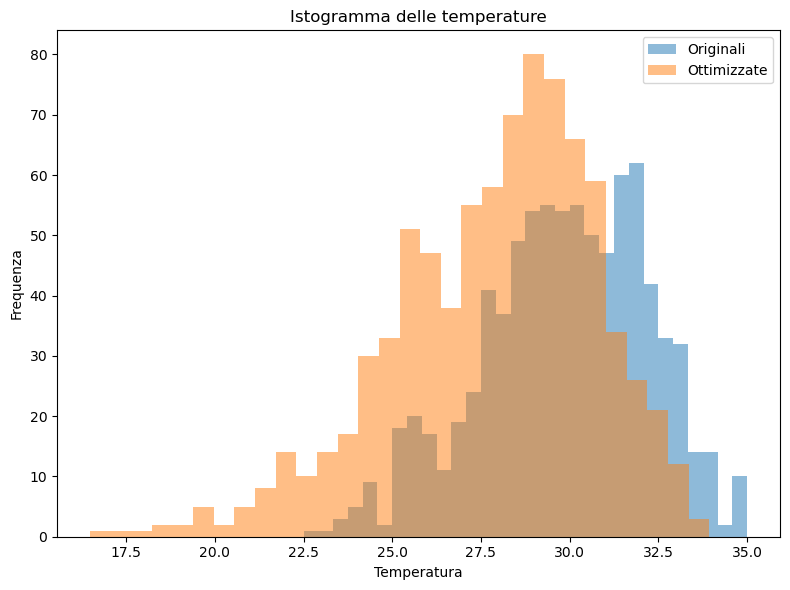

/var/folders/5q/7gvvb8f17xqfqy9bvvspk13w0000gn/T/ipykernel_7328/788803322.py:101: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Originali', 'Ottimizzate'])


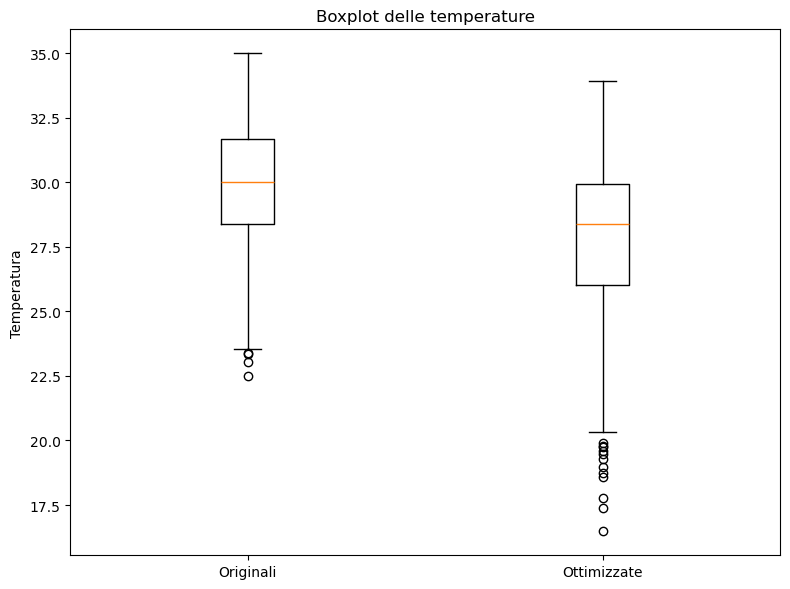

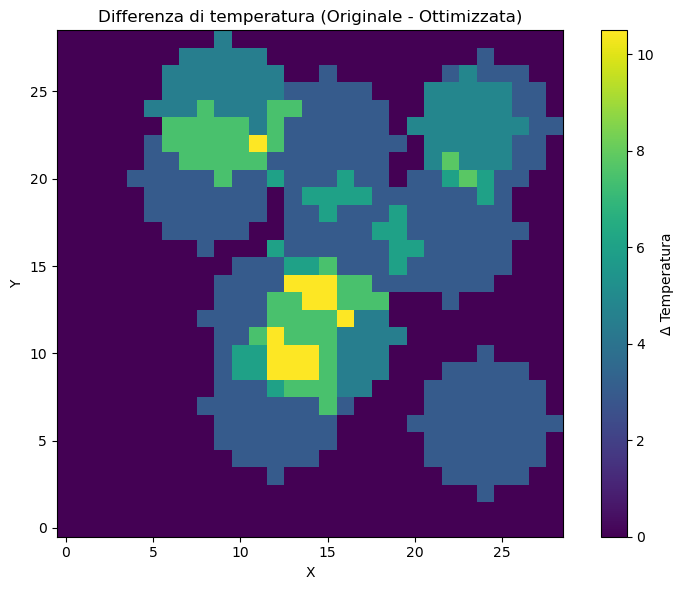

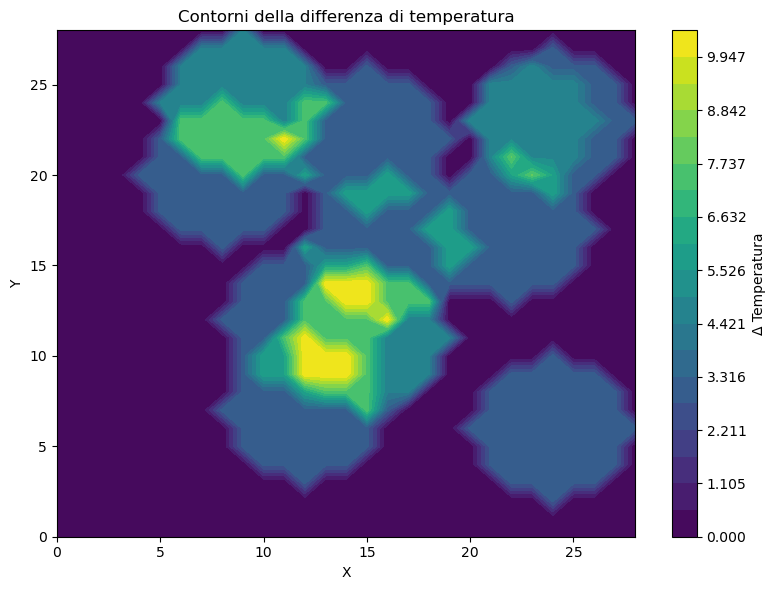

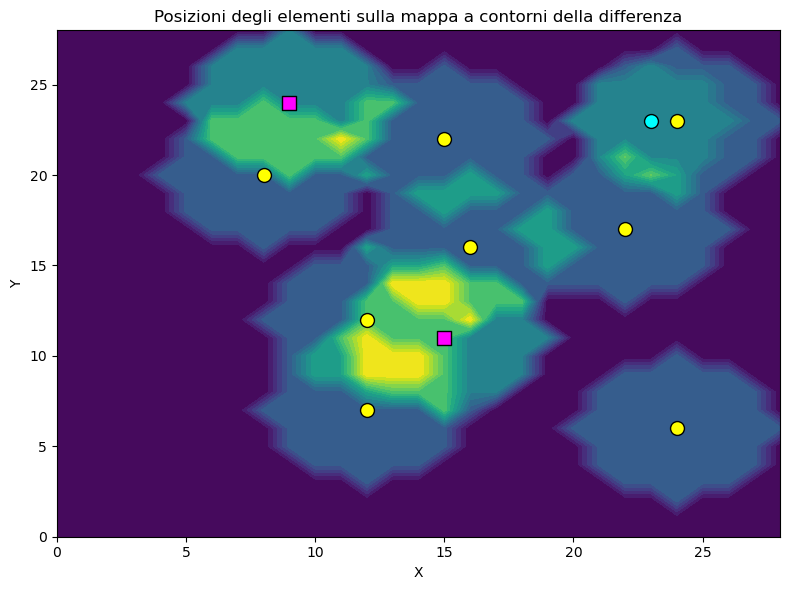

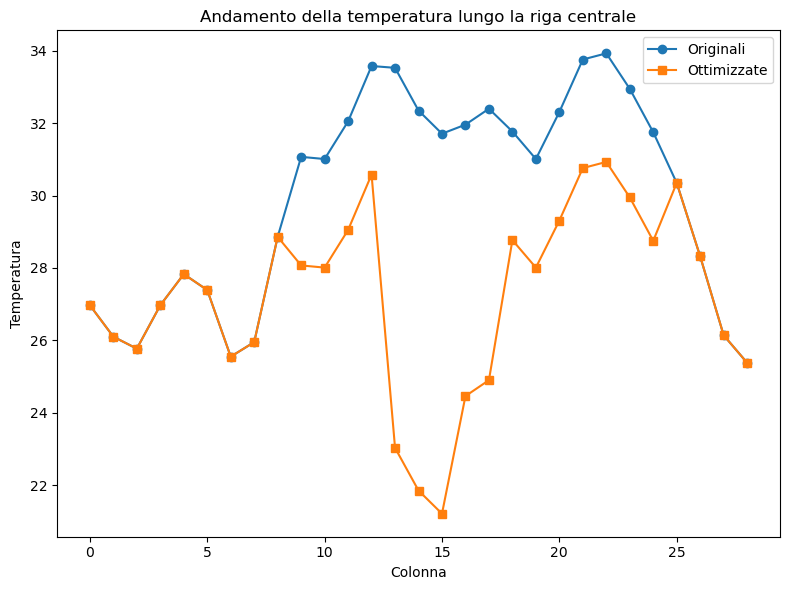

In [ ]:
# ===============================================================
# 6. Esecuzione di un singolo run e visualizzazione dei risultati
# ===============================================================
model = ga(function=objective,
           dimension=4 * num_candidates,
           variable_type='int',
           variable_boundaries=var_bound,
           algorithm_parameters=params)

model.run()
best_sol = model.output_dict['variable']
print("\n--- Risultato del singolo run ---")
print("Migliore soluzione trovata:", best_sol)

# Estrazione degli elementi piazzati dalla soluzione migliore
placed_elements = []  # Lista di tuple (row, col, candidate_type)
total_cost = 0
for i in range(num_candidates):
    row = int(round(best_sol[4*i]))
    col = int(round(best_sol[4*i + 1]))
    active = 1 if int(round(best_sol[4*i + 2])) >= 1 else 0
    candidate_type = int(round(best_sol[4*i + 3]))
    candidate_type = max(0, min(2, candidate_type))

    if active:
        if candidate_type == 2:
            total_cost += fountain_properties['cost']
        else:
            total_cost += tree_properties[candidate_type]['cost']
        placed_elements.append((row, col, candidate_type))

print("Elementi piazzati (alberi e fontane):", len(placed_elements))
for (row, col, candidate_type) in placed_elements:
    if candidate_type == 2:
        element_str = "Fontana"
    elif candidate_type == 0:
        element_str = "Albero potente"
    else:
        element_str = "Albero economico"
    print(f"Posizione: ({row}, {col}) - Tipo: {element_str}")
print("Costo totale:", total_cost)

# Calcolo della mappa finale delle temperature con effetto raffreddante
final_temp_opt = np.copy(temp_matrix)
Y, X = np.indices((H, W))
for (row_center, col_center, candidate_type) in placed_elements:
    if candidate_type == 2:
        props = fountain_properties
    else:
        props = tree_properties[candidate_type]
    rad = props['radius']
    cool = props['cooling']
    mask = (Y - row_center)**2 + (X - col_center)**2 <= rad**2
    final_temp_opt[mask] -= cool

# Statistiche finali
final_mean = np.mean(final_temp_opt)
final_max = np.max(final_temp_opt)
final_min = np.min(final_temp_opt)
final_var = np.var(final_temp_opt)
final_median = np.median(final_temp_opt)

print("\n=== Statistiche finali ottimizzate ===")
print("Media: {:.2f}".format(final_mean))
print("Massimo: {:.2f}".format(final_max))
print("Minimo: {:.2f}".format(final_min))
print("Varianza: {:.2f}".format(final_var))
print("Mediana: {:.2f}".format(final_median))

# Calcolo e stampa dei miglioramenti in percentuale
perc_mean = 100 * (original_mean - final_mean) / original_mean
perc_max = 100 * (original_max - final_max) / original_max
print("\nMiglioramento della media: {:.2f}%".format(perc_mean))
print("Riduzione del valore massimo: {:.2f}%".format(perc_max))

# Visualizzazione della mappa delle temperature ottimizzate
plt.figure(figsize=(8, 6))
plt.imshow(final_temp_opt, origin='lower', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.title("Mappa delle temperature ottimizzate")
plt.xlabel("X")
plt.ylabel("Y")
cbar = plt.colorbar()
cbar.set_label("Temperatura")
plt.tight_layout()
plt.show()

# Istogramma a confronto tra le temperature originali e quelle ottimizzate
plt.figure(figsize=(8, 6))
plt.hist(temp_matrix.flatten(), bins=30, alpha=0.5, label='Originali')
plt.hist(final_temp_opt.flatten(), bins=30, alpha=0.5, label='Ottimizzate')
plt.title("Istogramma delle temperature")
plt.xlabel("Temperatura")
plt.ylabel("Frequenza")
plt.legend()
plt.tight_layout()
plt.show()

# Boxplot per confrontare le distribuzioni
plt.figure(figsize=(8, 6))
data = [temp_matrix.flatten(), final_temp_opt.flatten()]
plt.boxplot(data, labels=['Originali', 'Ottimizzate'])
plt.title("Boxplot delle temperature")
plt.ylabel("Temperatura")
plt.tight_layout()
plt.show()

# Mappa della differenza tra le temperature originali e quelle ottimizzate
diff_temp = temp_matrix - final_temp_opt
plt.figure(figsize=(8, 6))
plt.imshow(diff_temp, origin='lower', cmap='viridis')
plt.title("Differenza di temperatura (Originale - Ottimizzata)")
plt.xlabel("X")
plt.ylabel("Y")
cbar = plt.colorbar()
cbar.set_label("Δ Temperatura")
plt.tight_layout()
plt.show()

# Plot a contorni della differenza di temperatura
plt.figure(figsize=(8, 6))
levels = np.linspace(np.min(diff_temp), np.max(diff_temp), 20)
contour = plt.contourf(diff_temp, levels=levels, cmap='viridis')
plt.title("Contorni della differenza di temperatura")
plt.xlabel("X")
plt.ylabel("Y")
cbar = plt.colorbar(contour)
cbar.set_label("Δ Temperatura")
plt.tight_layout()
plt.show()

# Scatter plot delle posizioni degli elementi sovrapposto alla mappa a contorni della differenza
plt.figure(figsize=(8, 6))
plt.contourf(diff_temp, levels=levels, cmap='viridis')
for (row_i, col_i, candidate_type) in placed_elements:
    if candidate_type == 2:
        marker = 's'
        color = 'magenta'
    elif candidate_type == 0:
        marker = 'o'
        color = 'yellow'
    else:
        marker = 'o'
        color = 'cyan'
    plt.scatter(col_i, row_i, marker=marker, s=100, edgecolor='black', color=color)
plt.title("Posizioni degli elementi sulla mappa a contorni della differenza")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# Sezione della mappa: andamento della temperatura lungo la riga centrale
row_central = H // 2
plt.figure(figsize=(8, 6))
plt.plot(temp_matrix[row_central, :], label='Originali', marker='o')
plt.plot(final_temp_opt[row_central, :], label='Ottimizzate', marker='s')
plt.title("Andamento della temperatura lungo la riga centrale")
plt.xlabel("Colonna")
plt.ylabel("Temperatura")
plt.legend()
plt.tight_layout()
plt.show()

# Multi-Run


--- Inizio Loop multiplo per analisi statistica ---

Sun 1/30
 The best solution found:                                                                           
 [ 8. 22.  1.  0. 16. 17.  0.  1. 15. 19.  1.  2. 20. 23.  0.  1. 17. 13.
  1.  0.  7.  4.  1.  0. 11. 14.  1.  0. 17. 13.  1.  0.  2.  2.  0.  1.
 28. 24.  0.  1. 24.  9.  1.  2. 10.  9.  1.  0.  8.  7.  1.  0.  4. 18.
  0.  0.  8.  7.  0.  0. 23. 23.  1.  1.  9.  9.  1.  2. 17. 20.  1.  0.
 12. 19.  1.  2. 10.  8.  0.  0.]

 Objective function:
 62.294233963721126


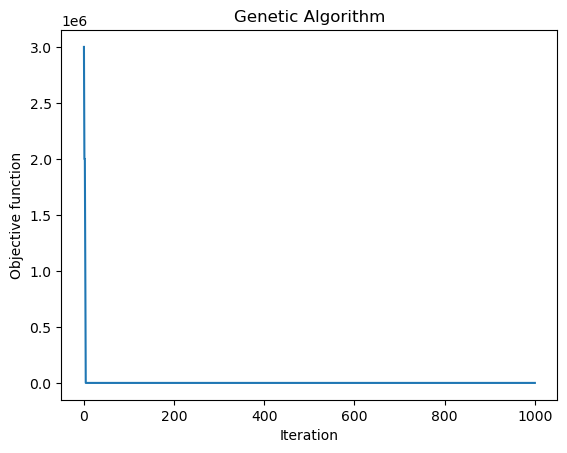

Sun 1: Temperatura finale = 27.34, Elementi piazzati = 13, Costo totale = 22580

Sun 2/30
 The best solution found:                                                                           
 [ 2. 26.  0.  1. 16. 14.  0.  0. 20.  4.  0.  1.  9. 12.  1.  1. 19. 13.
  1.  2. 11. 13.  1.  2. 12.  3.  0.  0.  2. 23.  0.  1. 13. 10.  1.  1.
 22.  7.  1.  0. 19. 26.  0.  1.  4. 24.  1.  2. 24.  9.  1.  2.  9. 20.
  1.  0. 19. 16.  1.  1.  5. 24.  1.  0.  0.  1.  0.  1. 19. 20.  1.  0.
 18. 12.  1.  0. 13. 19.  1.  0.]

 Objective function:
 62.389002732682656


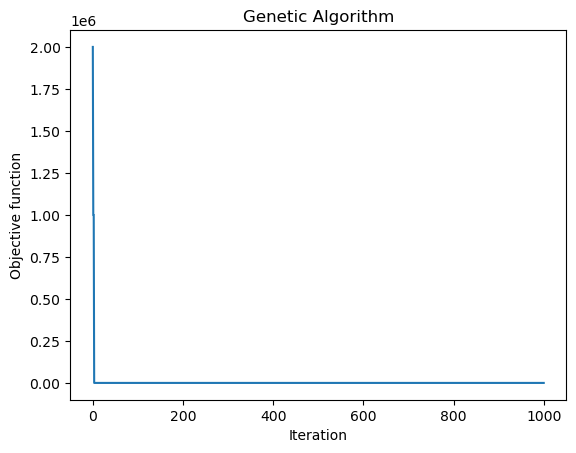

Sun 2: Temperatura finale = 27.57, Elementi piazzati = 13, Costo totale = 22340

Sun 3/30
 The best solution found:                                                                           
 [24.  9.  1.  2. 17. 11.  1.  0. 12. 23.  1.  0. 12.  4.  1.  0. 27. 21.
  0.  2. 11. 17.  1.  2. 23. 10.  0.  1. 12. 11.  1.  0. 15.  7.  1.  1.
 20.  8.  1.  0. 16.  7.  0.  2. 19.  0.  0.  1. 17. 22.  1.  0.  2. 28.
  0.  1. 11. 22.  1.  0.  8. 17.  1.  0. 11. 12.  1.  0.  3. 10.  0.  0.
 20. 16.  0.  1. 24.  9.  1.  0.]

 Objective function:
 61.96904546586018


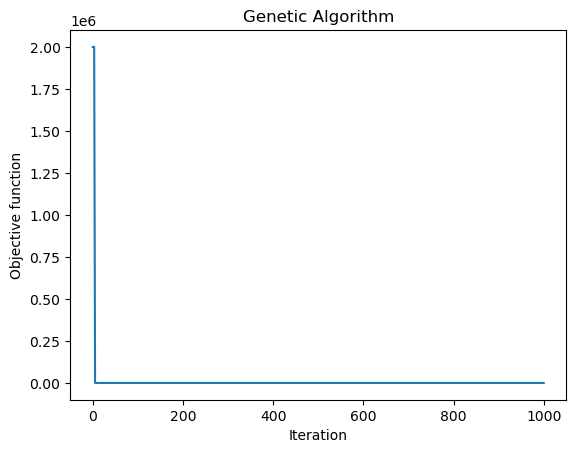

Sun 3: Temperatura finale = 27.52, Elementi piazzati = 13, Costo totale = 13180

Sun 4/30
 The best solution found:                                                                           
 [17. 24.  1.  0.  9.  3.  0.  0. 11. 24.  1.  0.  9. 16.  1.  1.  7. 14.
  0.  0. 19. 12.  1.  0. 12.  6.  1.  0. 17. 10.  1.  2. 25. 13.  0.  1.
 24.  2.  0.  0. 14. 12.  0.  1. 22. 13.  1.  0. 14.  7.  0.  1. 24.  9.
  1.  2. 11. 15.  1.  2.  8. 13.  1.  0.  2.  5.  0.  1. 17. 11.  0.  2.
 22. 13.  1.  0. 23. 22.  0.  2.]

 Objective function:
 62.06316993331042


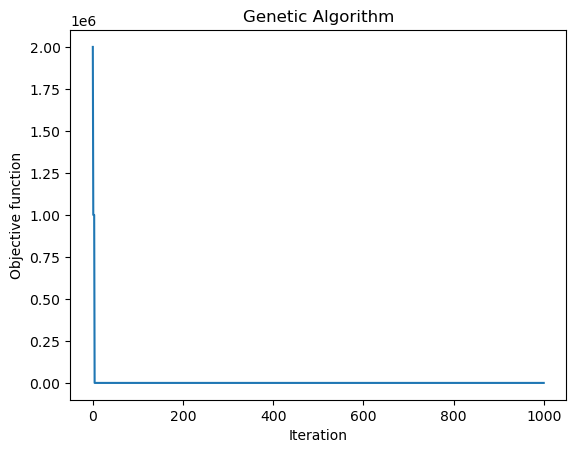

Sun 4: Temperatura finale = 27.78, Elementi piazzati = 11, Costo totale = 17280

Sun 5/30
 The best solution found:                                                                           
 [19. 13.  0.  0. 22. 18.  1.  0. 18.  5.  1.  0. 12. 19.  1.  2.  8. 26.
  0.  2.  3. 23.  0.  0. 22. 15.  1.  0. 24. 16.  1.  0. 10. 19.  1.  1.
 10. 17.  0.  0. 24.  9.  1.  2.  3. 20.  1.  1.  8.  3.  0.  0.  8.  9.
  1.  1. 10. 22.  1.  0. 16. 23.  1.  0. 11. 12.  1.  0. 19. 25.  0.  1.
 21. 18.  1.  0. 24. 14.  1.  0.]

 Objective function:
 61.812442922995494


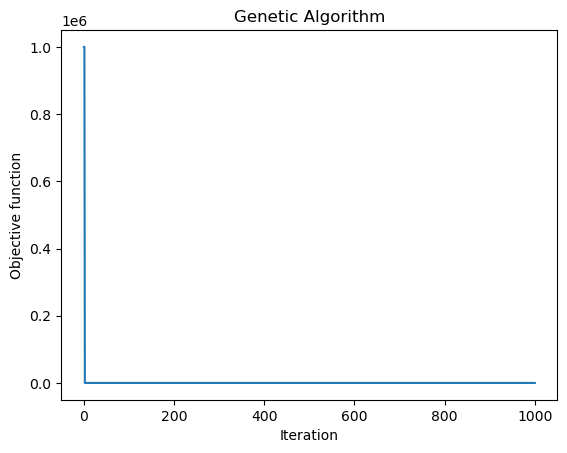

Sun 5: Temperatura finale = 27.57, Elementi piazzati = 14, Costo totale = 13240

Sun 6/30
 The best solution found:                                                                           
 [23.  6.  1.  2. 18. 25.  0.  1. 22. 23.  1.  0. 25. 21.  0.  2.  6. 22.
  0.  2. 14. 19.  0.  1.  9. 16.  1.  0. 10. 21.  1.  0.  8. 18.  0.  2.
 18.  9.  1.  1. 11. 10.  1.  0. 19. 25.  0.  1. 12.  5.  1.  2. 11.  8.
  1.  0. 18. 26.  0.  1. 24.  9.  1.  2. 12. 18.  0.  1.  9. 12.  1.  0.
 10. 19.  1.  0. 14.  6.  1.  2.]

 Objective function:
 62.36794051977694


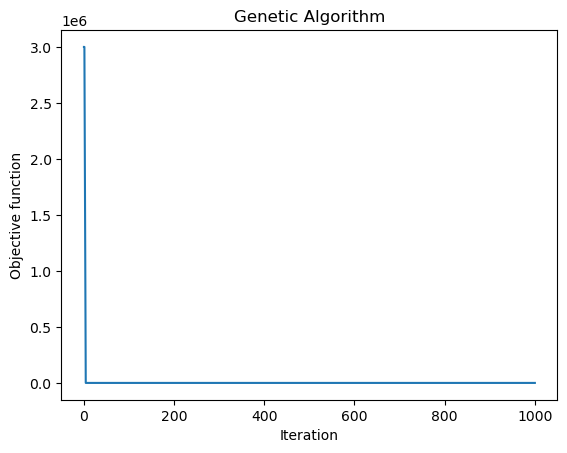

Sun 6: Temperatura finale = 27.52, Elementi piazzati = 12, Costo totale = 22280

Sun 7/30
 The best solution found:                                                                           
 [ 7. 20.  1.  0. 17. 22.  1.  0. 20. 26.  0.  2. 21.  3.  0.  0.  7. 10.
  1.  2. 16. 12.  1.  0. 10. 22.  1.  0. 27. 20.  0.  0. 19.  0.  0.  2.
 11. 16.  1.  0. 11. 13.  1.  2.  7. 17.  1.  1. 23.  6.  1.  0.  7. 10.
  1.  0. 28. 15.  0.  1.  9. 15.  0.  2. 24.  9.  1.  2.  1. 13.  0.  2.
  2. 10.  0.  0. 11. 12.  1.  2.]

 Objective function:
 62.372576786451006


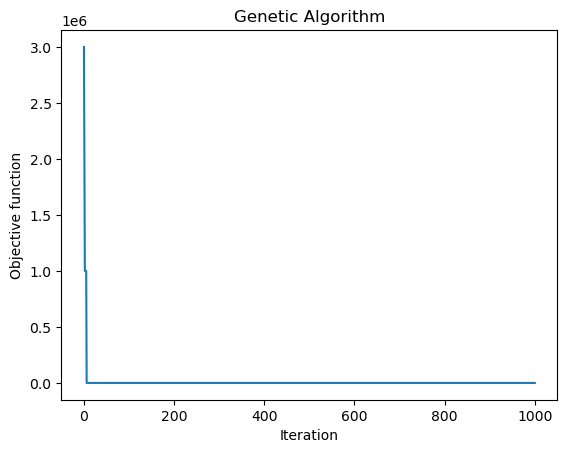

Sun 7: Temperatura finale = 27.52, Elementi piazzati = 12, Costo totale = 22280

Sun 8/30
 The best solution found:                                                                           
 [24. 14.  1.  0.  3.  6.  0.  2. 15. 23.  0.  1. 18.  3.  0.  1. 24.  9.
  1.  2. 11. 21.  1.  0. 14.  7.  1.  2. 15. 28.  0.  1. 19. 19.  1.  0.
 16.  6.  0.  0. 19. 21.  1.  0. 15.  7.  1.  2. 11. 12.  1.  2. 18.  7.
  1.  0.  0.  8.  0.  0.  9. 15.  0.  1. 10.  7.  1.  1. 13. 20.  1.  0.
  7. 12.  1.  0. 12. 25.  1.  1.]

 Objective function:
 62.15583810910628


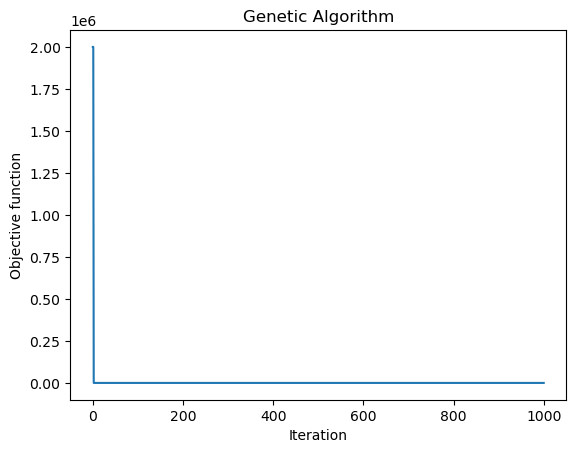

Sun 8: Temperatura finale = 27.46, Elementi piazzati = 13, Costo totale = 22460

Sun 9/30
 The best solution found:                                                                           
 [ 9. 14.  0.  0. 16. 23.  1.  0. 21. 13.  1.  0. 14. 11.  1.  1.  6. 10.
  1.  2. 11.  8.  1.  0. 19. 22.  0.  2. 10. 23.  1.  0. 16. 11.  0.  0.
 17. 11.  1.  2.  8. 28.  0.  2.  2. 28.  0.  1. 24.  9.  1.  2.  7. 22.
  0.  1.  6. 10.  1.  0. 20. 22.  1.  0. 22. 13.  1.  0.  6.  4.  1.  2.
 16. 19.  1.  0. 22. 28.  0.  2.]

 Objective function:
 61.82088477687784


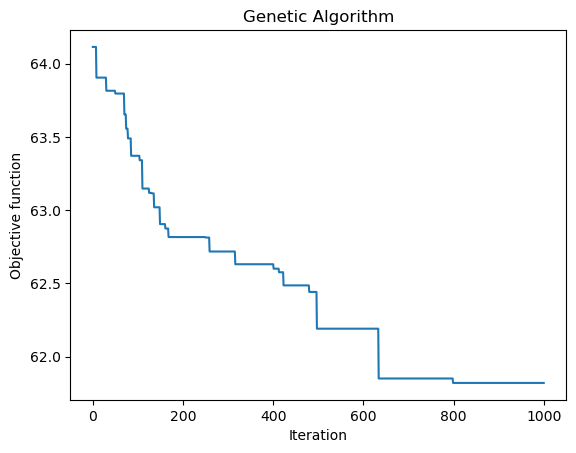

Sun 9: Temperatura finale = 27.34, Elementi piazzati = 13, Costo totale = 22580

Sun 10/30
 The best solution found:                                                                           
 [23.  4.  1.  1.  6. 17.  0.  0. 19.  7.  1.  2. 12.  5.  1.  2.  9. 12.
  1.  0.  4.  4.  1.  2. 24.  8.  1.  0.  9.  6.  0.  1. 10. 18.  1.  1.
 24. 14.  1.  0.  6. 24.  1.  0. 11. 20.  1.  0. 11. 15.  1.  0.  1.  4.
  0.  1. 11. 14.  1.  0. 18.  5.  1.  0. 22.  6.  0.  2. 26. 22.  0.  1.
 24.  7.  1.  2. 16. 22.  1.  0.]

 Objective function:
 61.900979521742826


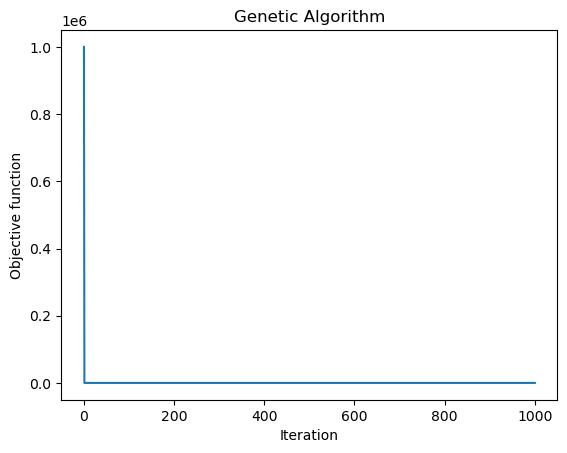

Sun 10: Temperatura finale = 27.11, Elementi piazzati = 15, Costo totale = 23060

Sun 11/30
 The best solution found:                                                                           
 [13. 17.  1.  1. 10. 14.  1.  1. 16.  1.  0.  0. 16. 12.  1.  0. 24.  9.
  1.  2. 21. 26.  0.  1.  6. 22.  1.  2. 16. 21.  1.  0. 23. 19.  1.  0.
  8. 12.  0.  2. 18. 13.  1.  0. 10.  0.  0.  0. 17. 21.  1.  0.  8. 19.
  1.  0.  6.  7.  0.  0. 22. 16.  1.  0. 19. 15.  1.  0. 22. 27.  0.  1.
  8.  9.  1.  2. 27. 12.  0.  0.]

 Objective function:
 62.38078746155274


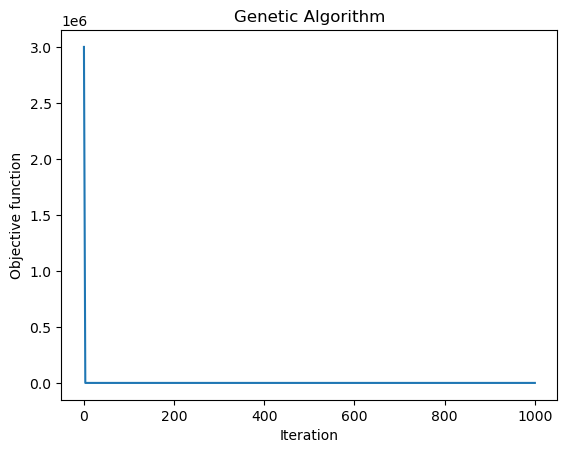

Sun 11: Temperatura finale = 27.54, Elementi piazzati = 13, Costo totale = 17760

Sun 12/30
 The best solution found:                                                                           
 [11. 17.  1.  0. 25.  4.  0.  2. 24. 14.  1.  0. 20.  3.  0.  1. 17.  6.
  1.  0. 17.  7.  1.  0. 19. 21.  1.  0.  4. 18.  0.  1. 25.  8.  1.  1.
 12. 20.  1.  0.  8.  8.  1.  0. 15.  8.  1.  0. 16. 10.  1.  2. 12. 11.
  0.  2. 19. 11.  1.  0. 18. 16.  1.  1. 15.  6.  1.  2.  9. 16.  0.  2.
 20. 23.  0.  2. 14. 25.  1.  1.]

 Objective function:
 62.53802150748058


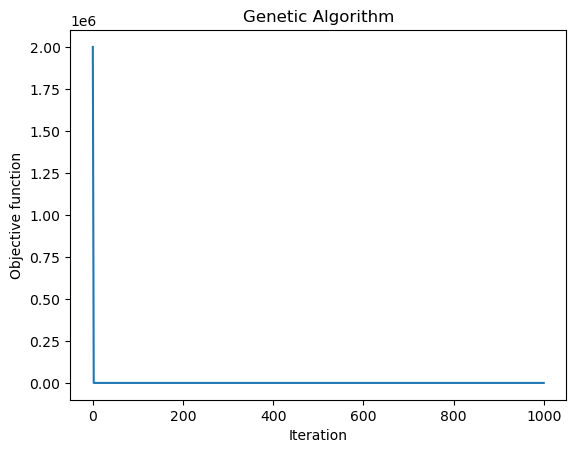

Sun 12: Temperatura finale = 27.57, Elementi piazzati = 14, Costo totale = 13240

Sun 13/30
 The best solution found:                                                                           
 [12.  8.  0.  2. 17. 22.  1.  0. 12. 23.  1.  0. 12. 18.  1.  2. 16. 13.
  0.  2. 13.  8.  1.  0.  9. 22.  0.  1. 21.  6.  1.  0. 24.  8.  1.  0.
  9. 20.  1.  0.  4.  7.  1.  0. 24.  9.  1.  2.  2. 16.  0.  1.  7. 12.
  1.  1.  8. 14.  1.  1. 26.  1.  0.  1. 20.  8.  0.  2. 21.  6.  1.  1.
 23. 21.  0.  0. 22. 15.  1.  0.]

 Objective function:
 62.12471780341569


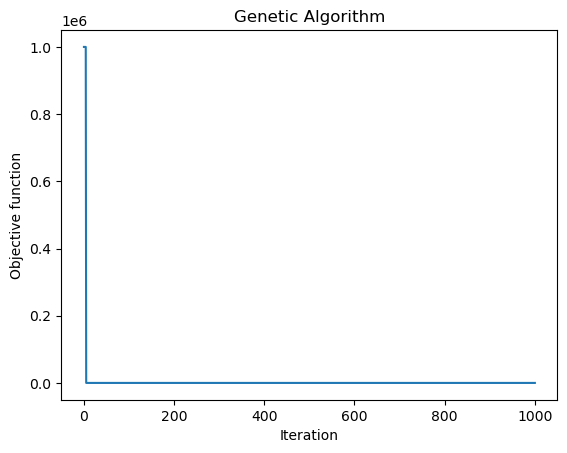

Sun 13: Temperatura finale = 27.74, Elementi piazzati = 13, Costo totale = 12940

Sun 14/30
 The best solution found:                                                                           
 [21. 13.  0.  0. 18. 10.  1.  1. 17.  6.  1.  2. 14. 14.  0.  2. 13. 21.
  0.  2. 21. 19.  1.  2. 24.  9.  1.  2.  9. 17.  1.  0. 27.  1.  0.  2.
  9. 23.  1.  0. 12.  4.  1.  0. 23. 13.  0.  1. 13.  9.  1.  0. 11. 19.
  1.  0. 18.  6.  1.  0. 11. 12.  1.  0. 20. 15.  0.  1.  8. 12.  1.  0.
 16. 23.  1.  0. 26.  8.  0.  1.]

 Objective function:
 62.33937379579281


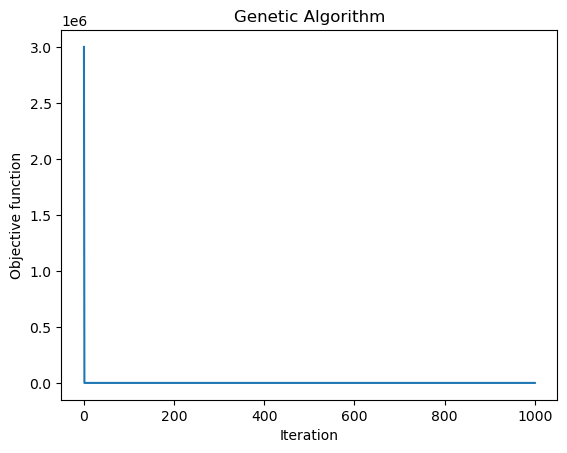

Sun 14: Temperatura finale = 27.43, Elementi piazzati = 13, Costo totale = 17880

Sun 15/30
 The best solution found:                                                                           
 [19.  9.  0.  0. 22.  7.  1.  1. 15.  8.  1.  2.  6. 12.  1.  0. 24. 17.
  0.  2. 14.  7.  1.  2.  0. 12.  0.  0. 19. 14.  0.  2. 20.  3.  1.  1.
 21. 19.  1.  2. 20. 19.  1.  0. 24. 14.  1.  0. 10. 21.  1.  0. 21. 19.
  1.  2. 21. 23.  1.  0. 10. 22.  0.  1. 22. 13.  1.  0. 12.  7.  1.  1.
 23. 23.  0.  1.  2. 24.  0.  1.]

 Objective function:
 62.255756275550596


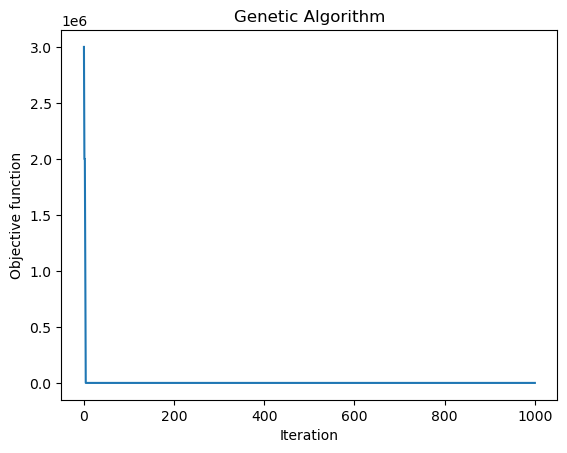

Sun 15: Temperatura finale = 27.57, Elementi piazzati = 13, Costo totale = 22340

Sun 16/30
 The best solution found:                                                                           
 [17. 22.  1.  0. 11.  4.  0.  1.  5. 17.  1.  1. 16. 10.  1.  2. 24. 16.
  1.  0. 15. 25.  0.  2.  7. 14.  0.  2. 12. 15.  1.  0.  8. 21.  1.  0.
 25. 11.  0.  2. 24.  9.  1.  2. 11. 15.  1.  2.  6. 22.  1.  2. 10. 23.
  0.  2.  6.  5.  1.  1.  8. 25.  0.  2. 15. 15.  0.  1. 12. 21.  1.  0.
 28. 14.  0.  2.  5.  5.  1.  0.]

 Objective function:
 62.21682339877924


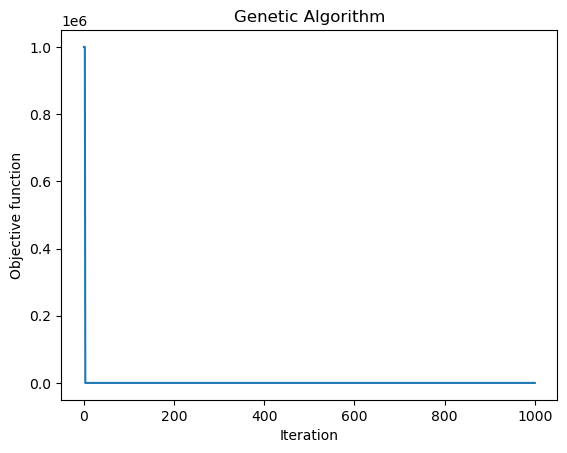

Sun 16: Temperatura finale = 27.63, Elementi piazzati = 12, Costo totale = 22160

Sun 17/30
 The best solution found:                                                                           
 [11. 15.  0.  2. 21. 18.  1.  0. 23.  4.  1.  0. 15.  6.  1.  0. 11. 13.
  1.  2. 17. 22.  1.  0. 22. 20.  1.  0. 24.  9.  1.  2.  6. 26.  0.  2.
 14. 24.  1.  0.  2.  3.  0.  1. 10.  0.  0.  1.  8. 14.  1.  0. 24. 26.
  0.  0. 14.  6.  1.  2. 11.  7.  0.  1. 19.  1.  0.  1. 17.  7.  1.  2.
  6.  7.  1.  0. 17. 23.  0.  2.]

 Objective function:
 62.38563839127172


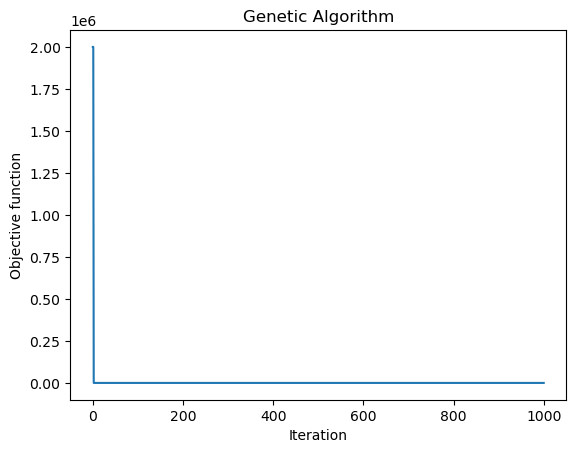

Sun 17: Temperatura finale = 27.41, Elementi piazzati = 12, Costo totale = 22400

Sun 18/30
 The best solution found:                                                                           
 [15.  7.  1.  2.  2. 14.  0.  2. 28. 21.  0.  1. 19. 10.  1.  0. 15. 21.
  0.  2.  5.  1.  0.  1.  9. 19.  1.  0. 15. 22.  0.  2.  8.  8.  1.  2.
 15. 11.  1.  1. 17. 20.  1.  0. 18.  7.  0.  2. 17. 13.  1.  0. 19. 20.
  1.  1. 11. 24.  1.  0. 24.  9.  1.  2. 19. 12.  0.  2. 10.  7.  1.  0.
  9. 19.  1.  0. 15.  2.  0.  2.]

 Objective function:
 62.4841868917812


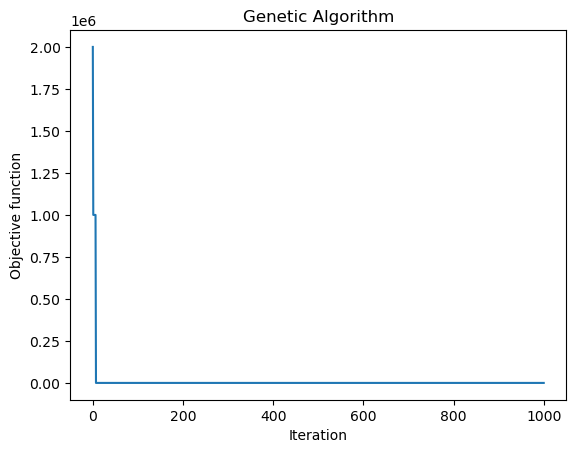

Sun 18: Temperatura finale = 27.72, Elementi piazzati = 12, Costo totale = 17460

Sun 19/30
 The best solution found:                                                                           
 [27.  5.  0.  2.  7. 10.  1.  2. 12. 21.  1.  0. 11.  6.  1.  0. 20.  5.
  1.  1.  6. 18.  1.  0.  5. 12.  1.  0. 20.  1.  0.  0. 22. 23.  1.  0.
 11.  0.  0.  2. 19.  4.  1.  2. 11. 20.  1.  0. 15. 15.  0.  1. 24.  6.
  1.  1.  6. 12.  1.  0. 24.  9.  1.  2. 22. 23.  1.  0. 19.  4.  1.  1.
  8.  9.  1.  2. 14.  7.  1.  0.]

 Objective function:
 62.145532556833956


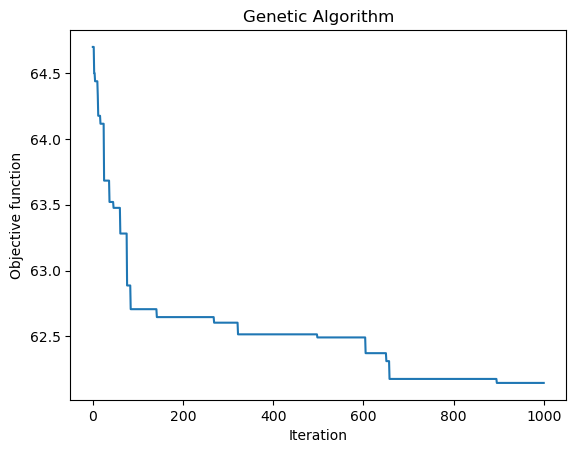

Sun 19: Temperatura finale = 27.05, Elementi piazzati = 16, Costo totale = 23240

Sun 20/30
 The best solution found:                                                                           
 [19. 23.  0.  1. 21.  7.  1.  0.  3. 20.  0.  1. 16. 10.  1.  0. 22. 16.
  1.  0. 14. 18.  1.  0. 10. 28.  0.  2. 20.  6.  1.  2. 28. 10.  0.  2.
 12. 18.  1.  2. 18. 18.  1.  1.  0.  1.  0.  0. 13. 15.  1.  0. 20. 22.
  1.  0.  3. 13.  1.  1. 18. 18.  0.  1. 24.  9.  1.  2.  7. 23.  1.  0.
 19. 13.  1.  0. 18. 22.  1.  0.]

 Objective function:
 62.241561991368876


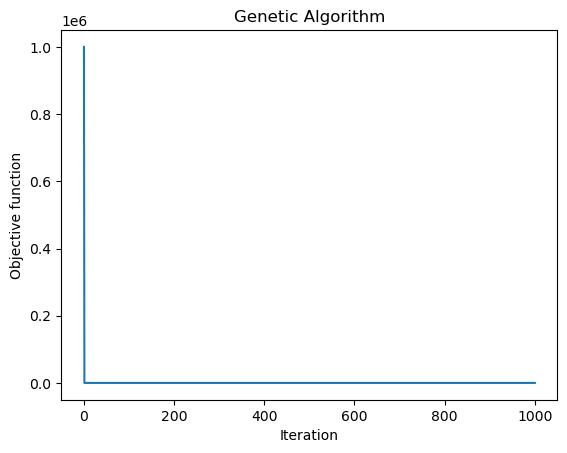

Sun 20: Temperatura finale = 27.37, Elementi piazzati = 14, Costo totale = 18060

Sun 21/30
 The best solution found:                                                                           
 [18.  5.  1.  1. 11. 23.  1.  1. 19. 13.  0.  0. 17.  5.  1.  0. 21. 21.
  0.  0. 20. 22.  1.  0.  1.  9.  0.  2. 19.  4.  1.  0. 16.  6.  1.  0.
 15.  5.  1.  1. 11. 23.  1.  0. 28. 24.  0.  1.  1.  8.  0.  0.  7. 12.
  1.  2.  9. 12.  0.  2.  6. 19.  1.  0. 28. 21.  0.  2. 17.  8.  1.  2.
 22. 13.  1.  0. 24.  9.  1.  2.]

 Objective function:
 62.210999851614204


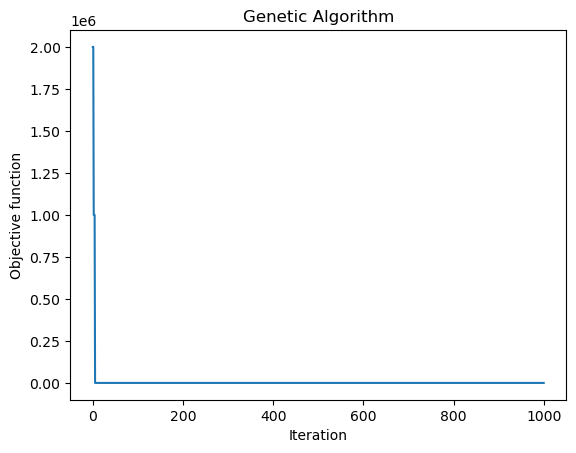

Sun 21: Temperatura finale = 27.66, Elementi piazzati = 13, Costo totale = 17640

Sun 22/30
 The best solution found:                                                                           
 [24.  9.  1.  2.  6. 16.  1.  0. 21.  4.  1.  0.  9. 23.  1.  0. 26. 26.
  0.  0. 19. 21.  1.  0. 17. 20.  1.  0.  4. 22.  1.  0.  1.  7.  0.  2.
 25. 14.  1.  1. 23. 16.  0.  1. 10. 19.  1.  1. 10.  9.  1.  0. 19.  8.
  0.  1. 21.  6.  1.  2. 17. 10.  1.  0. 15.  2.  0.  0.  1.  4.  0.  1.
  6. 17.  0.  0. 11. 17.  1.  2.]

 Objective function:
 62.18065293503226


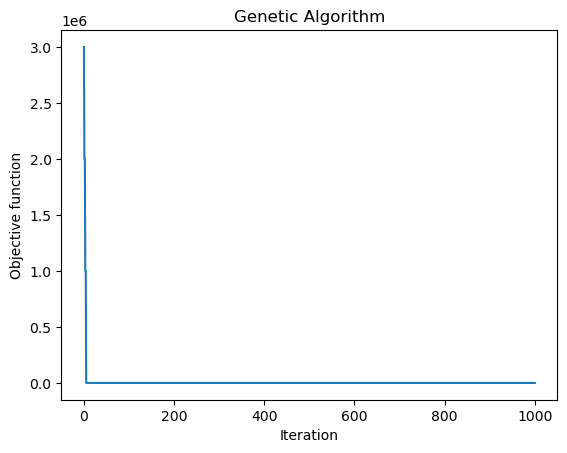

Sun 22: Temperatura finale = 27.54, Elementi piazzati = 13, Costo totale = 17760

Sun 23/30
 The best solution found:                                                                           
 [15.  7.  1.  0. 11.  6.  1.  0. 22.  2.  0.  0.  5. 14.  1.  0. 12. 19.
  0.  1.  1. 15.  0.  2.  8.  2.  0.  1. 10. 16.  1.  0.  9. 19.  1.  0.
 16. 21.  1.  0. 24.  9.  1.  2. 15. 24.  1.  1. 10. 20.  0.  2. 19. 18.
  0.  1. 14.  4.  1.  2.  6. 22.  1.  2. 17.  4.  0.  0.  5. 19.  1.  0.
 16. 19.  1.  0.  6. 17.  0.  0.]

 Objective function:
 62.430093413921554


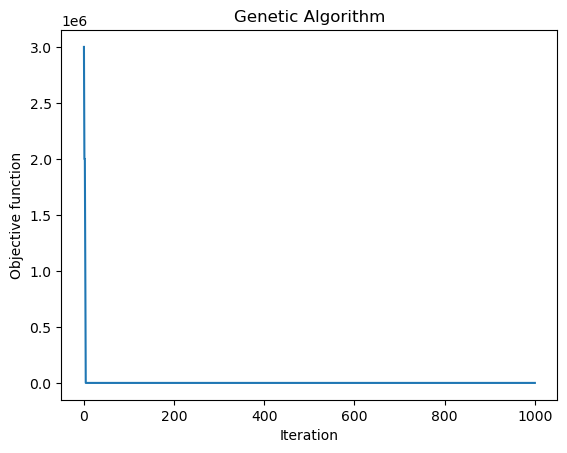

Sun 23: Temperatura finale = 27.61, Elementi piazzati = 12, Costo totale = 17580

Sun 24/30
 The best solution found:                                                                           
 [23. 16.  1.  0. 17.  9.  1.  0. 23. 19.  0.  2. 17. 10.  1.  0. 18. 13.
  1.  0. 20. 14.  0.  0. 15. 24.  1.  0. 25.  8.  0.  0. 11. 24.  1.  0.
 19.  9.  1.  2. 24. 28.  0.  2. 15.  8.  1.  0. 24.  9.  1.  2. 19.  5.
  0.  1. 16. 14.  1.  1. 23.  6.  1.  2. 16. 22.  1.  0.  0. 15.  0.  0.
 19.  9.  1.  0. 17.  5.  1.  2.]

 Objective function:
 62.05248229684295


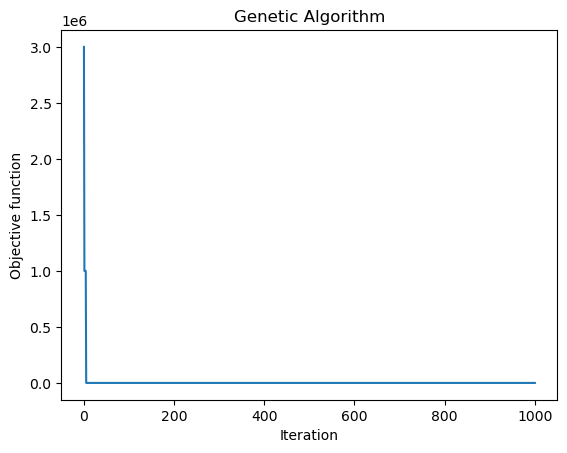

Sun 24: Temperatura finale = 27.17, Elementi piazzati = 14, Costo totale = 22880

Sun 25/30
 The best solution found:                                                                           
 [11. 24.  1.  0.  7.  8.  1.  0. 26. 14.  0.  1.  9. 18.  1.  0. 21.  9.
  0.  1. 20. 11.  0.  0. 17.  2.  0.  0. 13. 24.  0.  1.  6. 10.  1.  2.
 21. 19.  1.  2. 14. 15.  1.  0. 24.  9.  1.  2.  7. 20.  1.  0. 14. 16.
  1.  0. 19. 15.  0.  2. 24. 14.  1.  0.  0. 15.  0.  0. 15. 23.  1.  0.
  2.  0.  0.  0. 23. 19.  1.  1.]

 Objective function:
 62.17685728064577


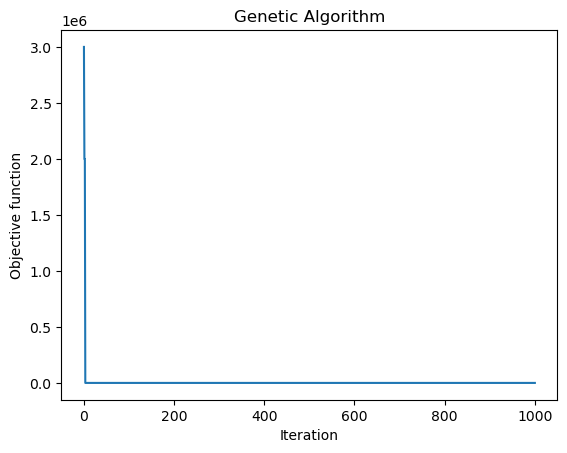

Sun 25: Temperatura finale = 27.61, Elementi piazzati = 12, Costo totale = 17580

Sun 26/30
 The best solution found:                                                                           
 [ 9. 17.  1.  2.  9.  6.  1.  0. 12.  3.  1.  1.  6. 21.  1.  0. 10. 20.
  1.  1. 19.  9.  1.  2. 21. 23.  1.  0. 22. 13.  1.  0.  1. 24.  0.  1.
 12. 18.  1.  2.  5. 19.  1.  0. 24.  9.  1.  2. 11. 23.  0.  2. 17. 14.
  0.  2.  7. 19.  1.  1. 23. 22.  0.  1. 12. 25.  0.  1. 11. 24.  1.  1.
 15. 24.  0.  1.  6. 25.  0.  2.]

 Objective function:
 62.22301948990419


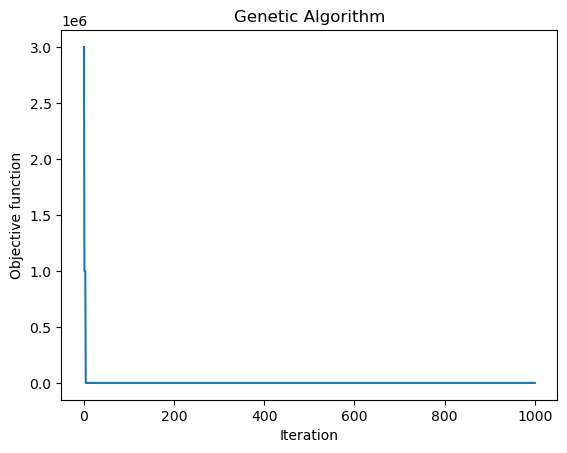

Sun 26: Temperatura finale = 27.68, Elementi piazzati = 13, Costo totale = 22220

Sun 27/30
 The best solution found:                                                                           
 [21. 12.  0.  1.  3. 20.  0.  1.  6. 10.  1.  0. 11.  7.  0.  0. 24.  9.
  1.  2. 24. 17.  1.  0.  1.  3.  0.  0. 27. 15.  0.  0.  7.  6.  1.  0.
 16. 19.  1.  1. 19. 28.  0.  2. 11. 24.  1.  0. 17. 21.  1.  2.  8. 13.
  1.  0. 12. 21.  0.  1. 18.  8.  1.  0.  6. 20.  1.  0. 22.  8.  1.  2.
 12. 18.  1.  2. 19. 13.  1.  0.]

 Objective function:
 62.12734041467563


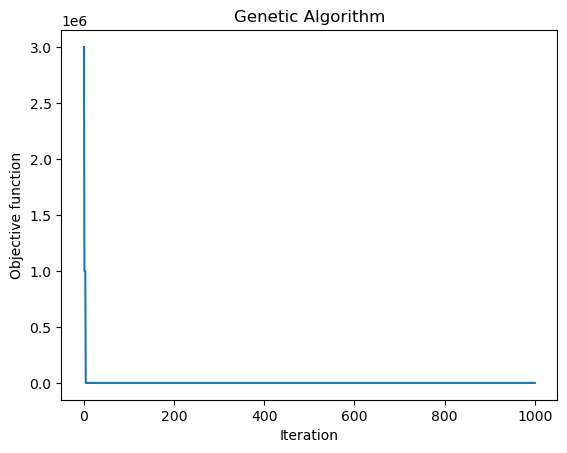

Sun 27: Temperatura finale = 27.34, Elementi piazzati = 13, Costo totale = 22580

Sun 28/30
 The best solution found:                                                                           
 [16. 21.  1.  0. 25. 16.  1.  1.  9. 23.  1.  0. 27. 27.  0.  0. 18.  1.
  0.  1. 19.  9.  1.  0.  7.  6.  1.  0. 24. 20.  0.  2. 24.  8.  1.  0.
 14.  1.  0.  0. 21.  7.  1.  0. 22. 13.  1.  0. 15. 21.  0.  0. 14. 23.
  0.  0. 18.  1.  0.  2. 11. 14.  1.  0.  9. 12.  0.  1. 21. 23.  1.  0.
 24.  9.  1.  0.  5. 12.  1.  0.]

 Objective function:
 62.20566589308511


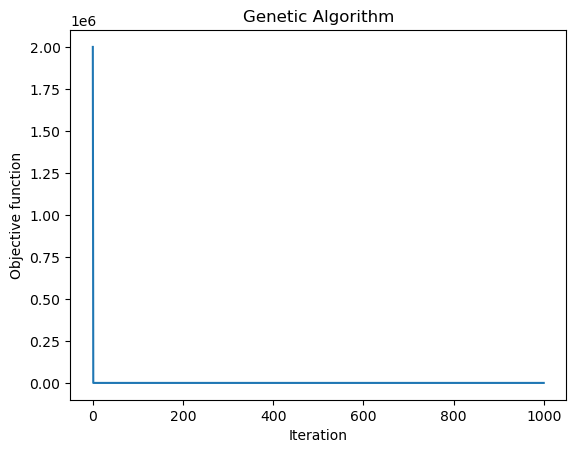

Sun 28: Temperatura finale = 27.87, Elementi piazzati = 12, Costo totale = 3480

Sun 29/30
 The best solution found:                                                                           
 [ 6. 22.  1.  2. 16.  7.  1.  0.  6.  9.  0.  0.  5. 15.  0.  1. 15.  5.
  0.  2.  7. 21.  0.  2. 17. 20.  1.  0. 22. 23.  0.  2. 23.  7.  1.  0.
 17. 17.  1.  0. 11.  6.  1.  2. 24.  9.  1.  2. 18. 12.  0.  1. 15. 23.
  1.  0. 22.  8.  1.  2.  4. 19.  1.  1. 18.  6.  1.  0.  2. 24.  0.  1.
  8.  5.  0.  2. 11. 20.  1.  0.]

 Objective function:
 62.25863159341115


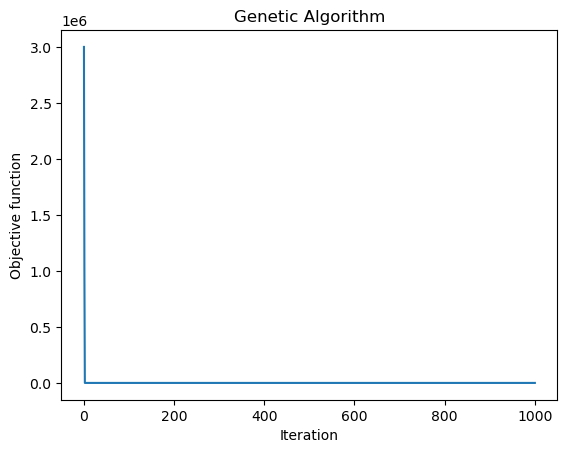

Sun 29: Temperatura finale = 27.52, Elementi piazzati = 12, Costo totale = 22280

Sun 30/30
||||||||||||||____________________________________ 27.0% GA is running...

In [ ]:
# ===============================================================
# 7. (Aggiornato) Loop multiplo per l'analisi statistica (multi-run)
# ===============================================================
num_runs = 30  # Numero di simulazioni ("Sun")

final_temps = []             # Lista delle temperature medie finali per ogni run
placed_elements_counts = []    # Numero di elementi piazzati per ogni run
total_costs = []             # Costo totale per ogni run
all_solutions = []           # Soluzioni ottenute
all_elements_details = []    # Dettagli degli elementi piazzati per ogni run
all_final_temp_matrices = [] # Matrici finali delle temperature per ogni run

print("\n--- Inizio Loop multiplo per analisi statistica ---")
for run in range(num_runs):
    print(f"\nSun {run+1}/{num_runs}")  # Stampa il numero della simulazione corrente

    model = ga(function=objective,
               dimension=4 * num_candidates,
               variable_type='int',
               variable_boundaries=var_bound,
               algorithm_parameters=params)
    model.run()
    best_sol = model.output_dict['variable']
    all_solutions.append(best_sol)

    placed_elements = []
    run_cost = 0
    for i in range(num_candidates):
        row = int(round(best_sol[4*i]))
        col = int(round(best_sol[4*i + 1]))
        active = 1 if int(round(best_sol[4*i + 2])) >= 1 else 0
        candidate_type = int(round(best_sol[4*i + 3]))
        candidate_type = max(0, min(2, candidate_type))
        if active:
            placed_elements.append((row, col, candidate_type))
            if candidate_type == 2:
                run_cost += fountain_properties['cost']
            else:
                run_cost += tree_properties[candidate_type]['cost']

    placed_elements_counts.append(len(placed_elements))
    total_costs.append(run_cost)
    all_elements_details.append(placed_elements)

    # Calcolo della mappa finale per il run corrente
    final_temp_opt = np.copy(temp_matrix)
    Y, X = np.indices((H, W))
    for (row_center, col_center, candidate_type) in placed_elements:
        if candidate_type == 2:
            props = fountain_properties
        else:
            props = tree_properties[candidate_type]
        rad = props['radius']
        cool = props['cooling']
        mask = (Y - row_center)**2 + (X - col_center)**2 <= rad**2
        final_temp_opt[mask] -= cool
    run_temp = np.mean(final_temp_opt)
    final_temps.append(run_temp)
    all_final_temp_matrices.append(final_temp_opt.copy())

    print(f"Sun {run+1}: Temperatura finale = {run_temp:.2f}, Elementi piazzati = {len(placed_elements)}, Costo totale = {run_cost}")

# ===============================================================
# 8. Analisi statistica aggregata dei risultati multi-run
# ===============================================================
import pandas as pd

runs_df = pd.DataFrame({
    'Final_Temp': final_temps,
    'Placed_Elements': placed_elements_counts,
    'Total_Cost': total_costs
})
print("\n--- Risultati aggregati ---")
print(runs_df.describe())

# Grafici statistici aggregati
plt.figure(figsize=(8,6))
plt.boxplot([runs_df['Final_Temp'], runs_df['Placed_Elements'], runs_df['Total_Cost']],
            labels=['Final Temp', 'Placed Elements', 'Total Cost'])
plt.title("Boxplot dei risultati aggregati")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.hist(runs_df['Final_Temp'], bins=10, alpha=0.7, label='Final Temp')
plt.hist(runs_df['Placed_Elements'], bins=10, alpha=0.7, label='Placed Elements')
plt.hist(runs_df['Total_Cost'], bins=10, alpha=0.7, label='Total Cost')
plt.title("Istogrammi dei risultati aggregati")
plt.xlabel("Valori")
plt.ylabel("Frequenza")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(runs_df['Total_Cost'], runs_df['Final_Temp'])
plt.title("Scatter: Total Cost vs. Final Temp")
plt.xlabel("Total Cost")
plt.ylabel("Final Temp")
plt.tight_layout()
plt.show()

# Grafici evolutivi per ogni Sun
plt.figure(figsize=(8,6))
plt.plot(range(1, num_runs+1), final_temps, marker='o', linestyle='-')
plt.title("Evoluzione della temperatura finale per Sun")
plt.xlabel("Sun")
plt.ylabel("Final Temp")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(1, num_runs+1), total_costs, marker='s', linestyle='-')
plt.title("Evoluzione del costo totale per Sun")
plt.xlabel("Sun")
plt.ylabel("Total Cost")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(1, num_runs+1), placed_elements_counts, marker='^', linestyle='-')
plt.title("Evoluzione degli elementi piazzati per Sun")
plt.xlabel("Sun")
plt.ylabel("Placed Elements")
plt.tight_layout()
plt.show()

# Selezione delle simulazioni migliori:
#   - Simulazione con costo totale minimo (meno spesa)
#   - Simulazione con temperatura finale minima (miglior abbassamento)
import numpy as np

best_cost_index = np.argmin(total_costs)
best_temp_index = np.argmin(final_temps)

print("\n--- Migliore simulazione per costo ---")
print(f"Sun {best_cost_index+1}: Costo totale = {total_costs[best_cost_index]}, Temperatura finale = {final_temps[best_cost_index]:.2f}, Elementi piazzati = {placed_elements_counts[best_cost_index]}")
print("Dettagli degli elementi:", all_elements_details[best_cost_index])

print("\n--- Migliore simulazione per temperatura ---")
print(f"Sun {best_temp_index+1}: Costo totale = {total_costs[best_temp_index]}, Temperatura finale = {final_temps[best_temp_index]:.2f}, Elementi piazzati = {placed_elements_counts[best_temp_index]}")
print("Dettagli degli elementi:", all_elements_details[best_temp_index])

# ===============================================================
# 9. Visualizzazione delle simulazioni migliori
# ===============================================================
# Definizioni comuni per la visualizzazione
cmap_types = mcolors.ListedColormap(['tab:red', 'tab:gray', 'tab:green', 'tab:blue'])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = mcolors.BoundaryNorm(bounds, cmap_types.N)
tree_color = {0: 'yellow', 1: 'cyan', 2: 'magenta'}  # Colori per gli elementi

# ----------------------------
# Visualizzazione simulazione migliore per costo
# ----------------------------
best_cost_elements = all_elements_details[best_cost_index]
best_cost_temp_matrix = all_final_temp_matrices[best_cost_index]

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(type_pivot, origin='lower', cmap=cmap_types, norm=norm)
for (row, col, candidate_type) in best_cost_elements:
    if candidate_type == 2:
        label = "Fontana"
    elif candidate_type == 0:
        label = "Albero potente"
    else:
        label = "Albero economico"
    circle = plt.Circle((col, row),
                        fountain_properties['radius'] if candidate_type==2 else tree_properties[candidate_type]['radius'],
                        color=tree_color[candidate_type], fill=False, linewidth=2)
    ax.add_patch(circle)
    ax.plot(col, row, 'ko', markersize=8)
    ax.text(col, row, label, color=tree_color[candidate_type],
            fontsize=10, fontweight='bold', ha='center', va='center')
ax.set_title("Simulazione Migliore per COSTO - Posizionamento Elementi")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.imshow(best_cost_temp_matrix, origin='lower', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.title("Simulazione Migliore per COSTO - Heatmap della Temperatura Finale")
plt.xlabel("X")
plt.ylabel("Y")
cbar = plt.colorbar()
cbar.set_label("Temperatura")
plt.tight_layout()
plt.show()

# ----------------------------
# Visualizzazione simulazione migliore per temperatura
# ----------------------------
best_temp_elements = all_elements_details[best_temp_index]
best_temp_temp_matrix = all_final_temp_matrices[best_temp_index]

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(type_pivot, origin='lower', cmap=cmap_types, norm=norm)
for (row, col, candidate_type) in best_temp_elements:
    if candidate_type == 2:
        label = "Fontana"
    elif candidate_type == 0:
        label = "Albero potente"
    else:
        label = "Albero economico"
    circle = plt.Circle((col, row),
                        fountain_properties['radius'] if candidate_type==2 else tree_properties[candidate_type]['radius'],
                        color=tree_color[candidate_type], fill=False, linewidth=2)
    ax.add_patch(circle)
    ax.plot(col, row, 'ko', markersize=8)
    ax.text(col, row, label, color=tree_color[candidate_type],
            fontsize=10, fontweight='bold', ha='center', va='center')
ax.set_title("Simulazione Migliore per TEMPERATURA - Posizionamento Elementi")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.imshow(best_temp_temp_matrix, origin='lower', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.title("Simulazione Migliore per TEMPERATURA - Heatmap della Temperatura Finale")
plt.xlabel("X")
plt.ylabel("Y")
cbar = plt.colorbar()
cbar.set_label("Temperatura")
plt.tight_layout()
plt.show()


# ACO Definition

In [ ]:
# ===============================================================
# 4.  Evaluation Function with Hot Cluster-Based Cooling
# ===============================================================
def evaluate_solution(solution, temp_matrix, cluster_grid, alpha=1.0, beta=1.0):
    """Calculate the objective function using Gaussian cooling effects on hot regions."""
    final_temp = np.array(temp_matrix)  # Copy of the original temperature grid
    H, W = final_temp.shape
    Y, X = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")

    # Apply cooling effects from each tree
    for tree, (row_center, col_center) in solution:
        props = tree_properties[tree]
        sigma = props["radius"] / 2.0  # Gaussian decay

        dist2 = (Y - row_center) ** 2 + (X - col_center) ** 2
        effect = props["cooling"] * np.exp(-dist2 / (2 * sigma ** 2))

        final_temp -= effect  # Apply cooling

    # Calculate temperature reductions
    mean_temp_reduction = np.sum(temp_matrix - final_temp)

    # Compute heat island impact (using hot clusters)
    heat_island_reduction = 0
    for row, col in np.argwhere(cluster_grid >= 0):  # Hot regions from DBSCAN
        heat_island_reduction += (temp_matrix[row, col] - final_temp[row, col]) * 1.5

    return alpha * mean_temp_reduction + beta * heat_island_reduction

# ===============================================================
# 4a.  check budget constraint
# ===============================================================
def evaluate_used_budget(tree_placement, budget_max, tree_properties, cost_factor=1.5):
    """Evaluate the used budget after placing trees."""
    total_cost = 0

    # Loop through all tree placements and accumulate the costs
    for tree, (row, col) in tree_placement:
        cost_factor = cost_factor if type_matrix[row, col] == 1 else 1.0  # Apply road cost factor if placed on roads
        tree_cost = tree_properties[tree]["cost"] * cost_factor  # Get cost of tree considering the cost factor
        total_cost += tree_cost

    # Evaluate remaining budget
    remaining_budget = budget_max - total_cost
    return total_cost, remaining_budget

### decisional vectomr definition

In [ ]:
# ===============================================================
# 5. Definition of update pheromone and probabilistic selection
# ===============================================================
def update_pheromone(best_solution, pheromone, evaporation_rate=0.1, reinforcement=1.0):
    """Update pheromone levels with evaporation and reinforcement."""

    # 1. Evaporation step (applies to all cells)
    pheromone *= (1 - evaporation_rate)

    # 2. Reinforcement step (only apply to tree placements)
    for tree, (row, col) in best_solution:
        pheromone[row, col] += reinforcement

def probabilistic_selection(type_matrix, pheromone, budget_remaining):
    """Choose a cell and tree species based on pheromone levels and constraints."""
    feasible_choices = []

    H, W = type_matrix.shape  # Grid size
    for row in range(H):
        for col in range(W):
            if type_matrix[row, col] not in {1, 2}:  # Trees only on roads (1) & green spaces (2)
                continue

            for tree in tree_properties.keys():
                if tree_properties[tree]['cost'] <= budget_remaining:
                    probability = pheromone[row, col] * tree_properties[tree]['cooling']
                    feasible_choices.append((tree, (row, col), probability))

    if not feasible_choices:
        return None, None

    # Weighted random choice
    trees, indices, probabilities = zip(*feasible_choices)
    chosen_idx = random.choices(range(len(feasible_choices)), weights=probabilities, k=1)[0]
    return trees[chosen_idx], indices[chosen_idx]

### Algorhitm parameter

In [ ]:
# ===============================================================
# 5. Definition of ant colony optimization
# ===============================================================
# Improvements:
# - apply pheromone levels for trees, i.e. initialize 1 for each tree in tree
# properties. And then update based on solution (see block above function update pheromone and dependency probabilistic choice)
# - try to tune params: evaporation rate and reinforcement -> algorithm can get
# stuck really fast in solution at the moment (params line 13)
# change output format from (tree,(row,col)) to (row, col, tree) (line 48 but also dependencies)
def ant_colony_optimization(type_matrix, temp_matrix, tree_properties,
                            iterations=200, num_ants=10,
                            alpha=1.0, beta=1.0, cost_factor = 1.5,
                            evaporation_rate=0.05, reinforcement = .3):
    """Ant Colony Optimization for tree placement with grid-based constraints."""
    cluster_grid,_ = get_heat_islands(temp_matrix)
    min_tree_cost = min(tree["cost"] for tree in tree_properties.values())

    H, W = type_matrix.shape  # Grid dimensions
    pheromone = np.ones((H, W))  # Initialize pheromone matrix
    best_solution = []
    best_quality = float('-inf')

    for _ in range(iterations):
        for _ in range(num_ants):
            solution = []
            budget_remaining = budget_max
            used_cells = set()  # Track occupied cells

            while budget_remaining >= min_tree_cost:
                tree, (row, col) = probabilistic_selection(type_matrix, pheromone, budget_remaining)

                if tree is None or (row, col) in used_cells:
                    break  # No valid placement

                # Apply road cost factor
                cost_factor = cost_factor if type_matrix[row, col] == 1 else 1.0
                tree_cost = tree_properties[tree]["cost"] * cost_factor

                # Ensure budget allows placement
                if budget_remaining >= tree_cost:
                  solution.append((tree, (row, col)))
                  used_cells.add((row, col))
                  budget_remaining -= tree_cost

            # Evaluate solution
            quality = evaluate_solution(solution, temp_matrix, cluster_grid,
                                        alpha,beta)
            _, remaining_budget = evaluate_used_budget(solution, budget_max,tree_properties)
            if quality > best_quality and remaining_budget > -1:
                best_solution = solution
                best_quality = quality

        update_pheromone(best_solution,pheromone, evaporation_rate, reinforcement)

    return best_solution



In [ ]:
# Run ACO
normal_placement =  ant_colony_optimization(type_matrix, temp_matrix,tree_properties)
heat_island_placement = ant_colony_optimization(type_matrix, temp_matrix,tree_properties, beta=10)
overall_placement = ant_colony_optimization(type_matrix, temp_matrix,tree_properties, alpha=10)
tree_placements = [normal_placement, heat_island_placement, overall_placement]

for placement in tree_placements:
    print(f'Number of trees in placement: {len(placement)}')

Number of trees in placement: 20
Number of trees in placement: 14
Number of trees in placement: 20


## Visualization


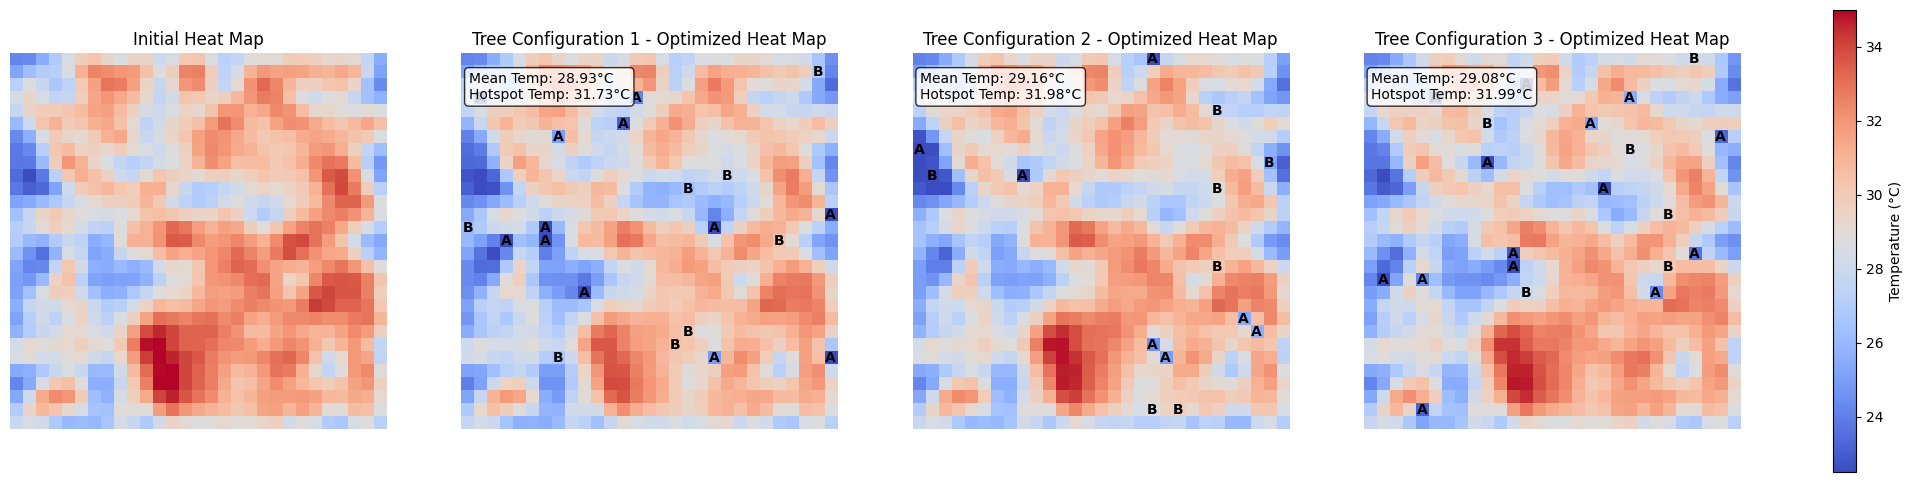

In [ ]:
# Define tree symbols
tree_symbols = {0: "A", 1: "B"}

import numpy as np
import matplotlib.pyplot as plt

def visualize_tree_placements(type_matrix, temp_matrix, tree_configurations):
    """Visualize initial and optimized heat maps with tree placements for multiple configurations."""
    cluster_grid,_ = get_heat_islands(temp_matrix)
    num_configurations = len(tree_configurations)
    fig, axes = plt.subplots(1, num_configurations + 1, figsize=(6 * (num_configurations + 1), 6))

    # Initial Heat Map
    ax1 = axes[0]
    im1 = ax1.imshow(temp_matrix, cmap='coolwarm', interpolation='nearest', vmin=temp_matrix.min(), vmax=temp_matrix.max())
    ax1.set_title("Initial Heat Map")
    ax1.axis('off')

    # Loop through each tree configuration and create a separate plot
    for i, tree_placements in enumerate(tree_configurations):
        updated_temp = np.array(temp_matrix)  # Copy the original temperature matrix
        H, W = updated_temp.shape
        Y, X = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")

        # Apply Tree Cooling Effects for the specific configuration
        for tree, (row_center, col_center) in tree_placements:
            props = tree_properties[tree]
            sigma = props["radius"] / 2.0  # Gaussian decay spread

            # Compute squared distance from tree location
            dist2 = (Y - row_center) ** 2 + (X - col_center) ** 2

            # Apply cooling effect with Gaussian decay
            effect = props["cooling"] * np.exp(-dist2 / (2 * sigma**2))
            updated_temp -= effect

        # Create a subplot for this configuration
        ax = axes[i + 1]
        im = ax.imshow(updated_temp, cmap='coolwarm', interpolation='nearest', vmin=temp_matrix.min(), vmax=temp_matrix.max())
        ax.set_title(f"Tree Configuration {i+1} - Optimized Heat Map")
        ax.axis('off')

        # Overlay Trees as Letters
        for tree, (row, col) in tree_placements:
            ax.text(col, row, tree_symbols.get(tree, "?"), ha="center", va="center",
                    fontsize=10, color="black", fontweight="bold")

        # Compute Mean Temperatures
        overall_mean = np.mean(updated_temp)
        hotspot_mean = np.mean(updated_temp[cluster_grid >= 0])  # Only hot region clusters

        # Add Text Box with Statistics
        text_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
        ax.text(0.02, 0.95, f"Mean Temp: {overall_mean:.2f}°C\nHotspot Temp: {hotspot_mean:.2f}°C",
                transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=text_props)

    # Shared Color Bar
    fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.05, label="Temperature (°C)")

    plt.show()


# Call the visualization function
visualize_tree_placements(type_matrix, temp_matrix, tree_placements)

In [ ]:
for placement in tree_placements:
    total_cost, remaining_budget = evaluate_used_budget(placement, budget_max,tree_properties)
    print(f"Total Cost: {total_cost}, Remaining Budget: {remaining_budget}")

Total Cost: 6000.0, Remaining Budget: 0.0
Total Cost: 4350.0, Remaining Budget: 1650.0
Total Cost: 6000.0, Remaining Budget: 0.0
